# Partie A: Clustering

- **Dataset**: Mall Customer Segmentation Data
- **Objectifs**: Segmenter les clients du centre commercial en groupes homogènes.

In [1]:
# Importation des librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Chargement:
Chargement du fichier `Mall_Customer.csv`

In [2]:
# Importation des données clients depuis le fichier CSV Mall_Customers.csv
dataset = pd.read_csv('dataset/Mall_Customers.csv')
dataset.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 2. Nettoyage et prétraitement:

In [3]:
# Étape 1 : Nettoyage et encodage des données (sans standardisation)
dataset['Gender'].dropna(inplace=True)
dataset['Age'] = dataset['Age'].fillna(18)
dataset['Annual Income (k$)'] = dataset['Annual Income (k$)'].fillna(dataset['Annual Income (k$)'].median())
dataset['Spending Score (1-100)'] = dataset['Spending Score (1-100)'].fillna(dataset['Spending Score (1-100)'].median())
dataset['Gender'] = dataset['Gender'].replace({"Male": 0, "Female": 1})

print("Données après nettoyage (sans standardisation) :")
print(dataset.head())

Données après nettoyage (sans standardisation) :
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       0   19                  15                      39
1           2       0   21                  15                      81
2           3       1   20                  16                       6
3           4       1   23                  16                      77
4           5       1   31                  17                      40


/tmp/ipykernel_66119/3816823043.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Gender'] = dataset['Gender'].replace({"Male": 0, "Female": 1})


In [4]:
# Étape 2 : Standardisation des variables quantitatives
scaler = StandardScaler()
cols_quantitatives = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
dataset_standardized = dataset.copy()  # Pour garder une version à part

dataset_standardized[cols_quantitatives] = scaler.fit_transform(dataset_standardized[cols_quantitatives])

print("\nDonnées après standardisation (valeurs centrées et réduites) :")
print(dataset_standardized.head())


Données après standardisation (valeurs centrées et réduites) :
   CustomerID  Gender       Age  Annual Income (k$)  Spending Score (1-100)
0           1       0 -1.424569           -1.738999               -0.434801
1           2       0 -1.281035           -1.738999                1.195704
2           3       1 -1.352802           -1.700830               -1.715913
3           4       1 -1.137502           -1.700830                1.040418
4           5       1 -0.563369           -1.662660               -0.395980


# 3. EDA univariée et multivariée :

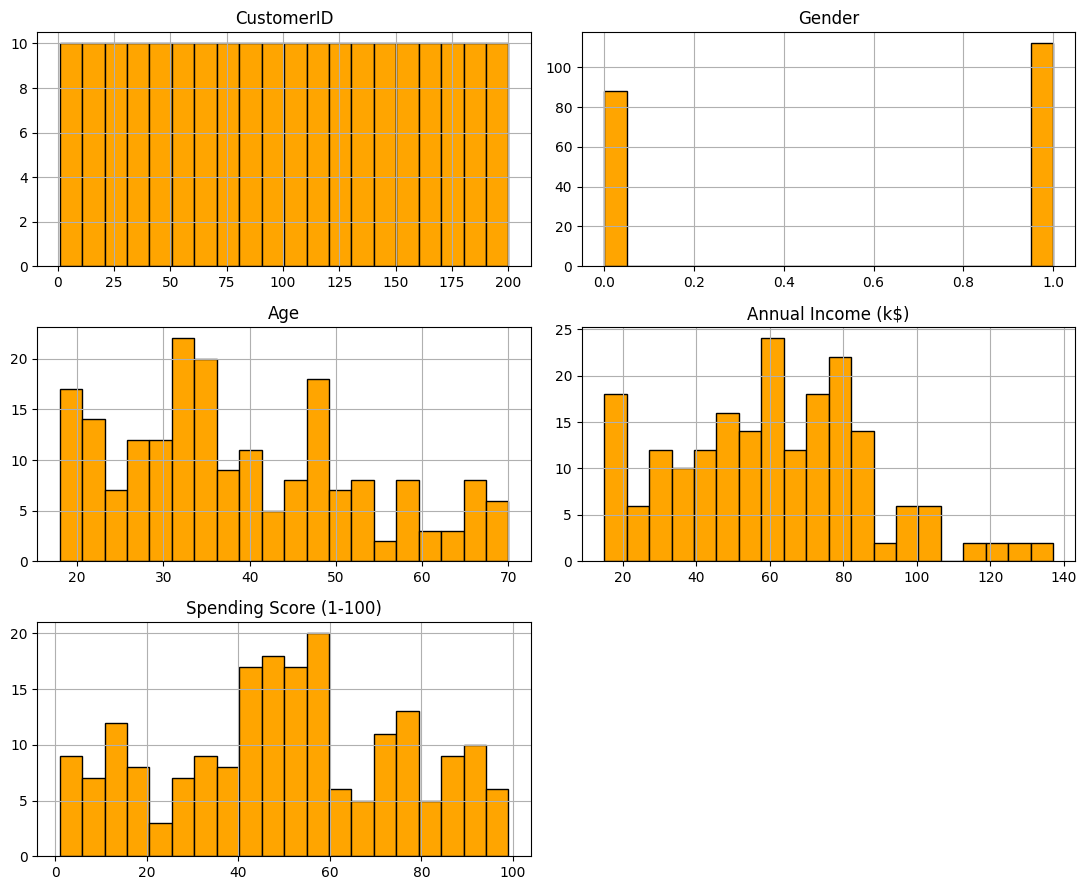

In [5]:
# 1. Tracer les histogrammes pour observer la distribution des variables numériques
fig = dataset.hist(bins=20, figsize=(11, 9), color='orange', edgecolor='black')
plt.tight_layout()
plt.show()

<Figure size 1100x900 with 0 Axes>

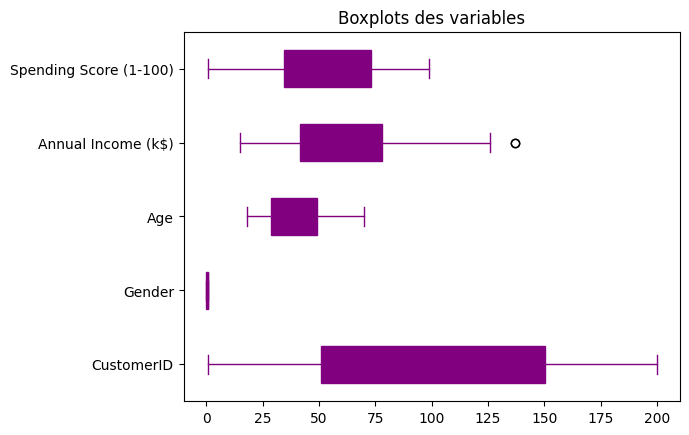

In [6]:
# 2. Afficher des boxplots pour détecter les éventuelles valeurs aberrantes
plt.figure(figsize=(11, 9))
dataset.plot(kind='box', vert=False, patch_artist=True, color='purple')
plt.title("Boxplots des variables")
plt.show()

In [7]:
# 3. Calcul de la corrélation entre variables numériques
correlations = dataset.corr()
print("Voici la matrice des corrélations :")
print(correlations)

Voici la matrice des corrélations :
                        CustomerID    Gender       Age  Annual Income (k$)  \
CustomerID                1.000000 -0.057400 -0.026763            0.977548   
Gender                   -0.057400  1.000000 -0.060867           -0.056410   
Age                      -0.026763 -0.060867  1.000000           -0.012398   
Annual Income (k$)        0.977548 -0.056410 -0.012398            1.000000   
Spending Score (1-100)    0.013835  0.058109 -0.327227            0.009903   

                        Spending Score (1-100)  
CustomerID                            0.013835  
Gender                                0.058109  
Age                                  -0.327227  
Annual Income (k$)                    0.009903  
Spending Score (1-100)                1.000000  


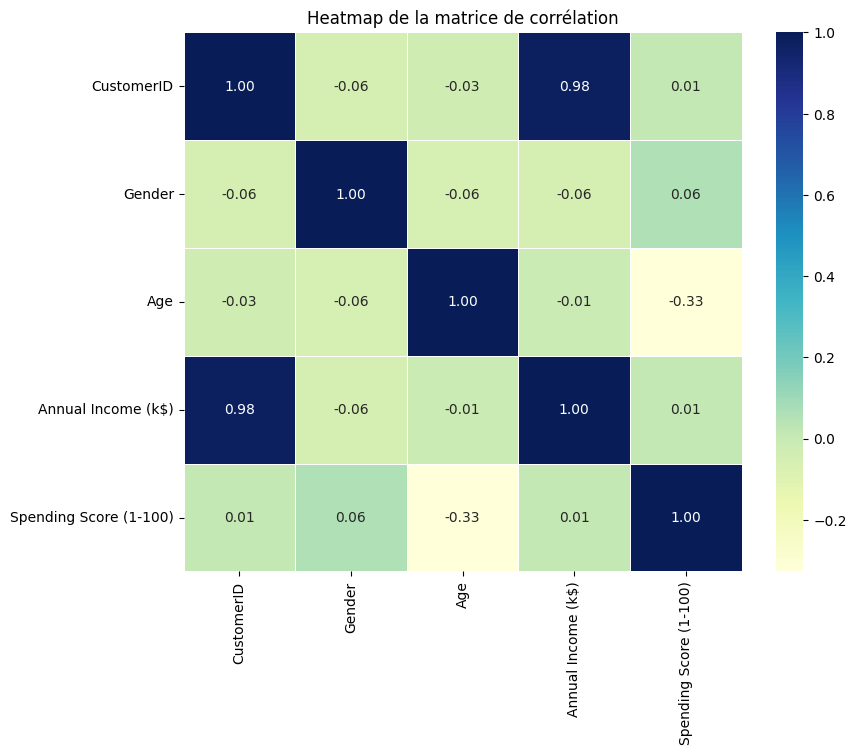

In [8]:
# 4. Visualisation graphique de la matrice de corrélation avec une heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlations, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.6)
plt.title("Heatmap de la matrice de corrélation")
plt.show()

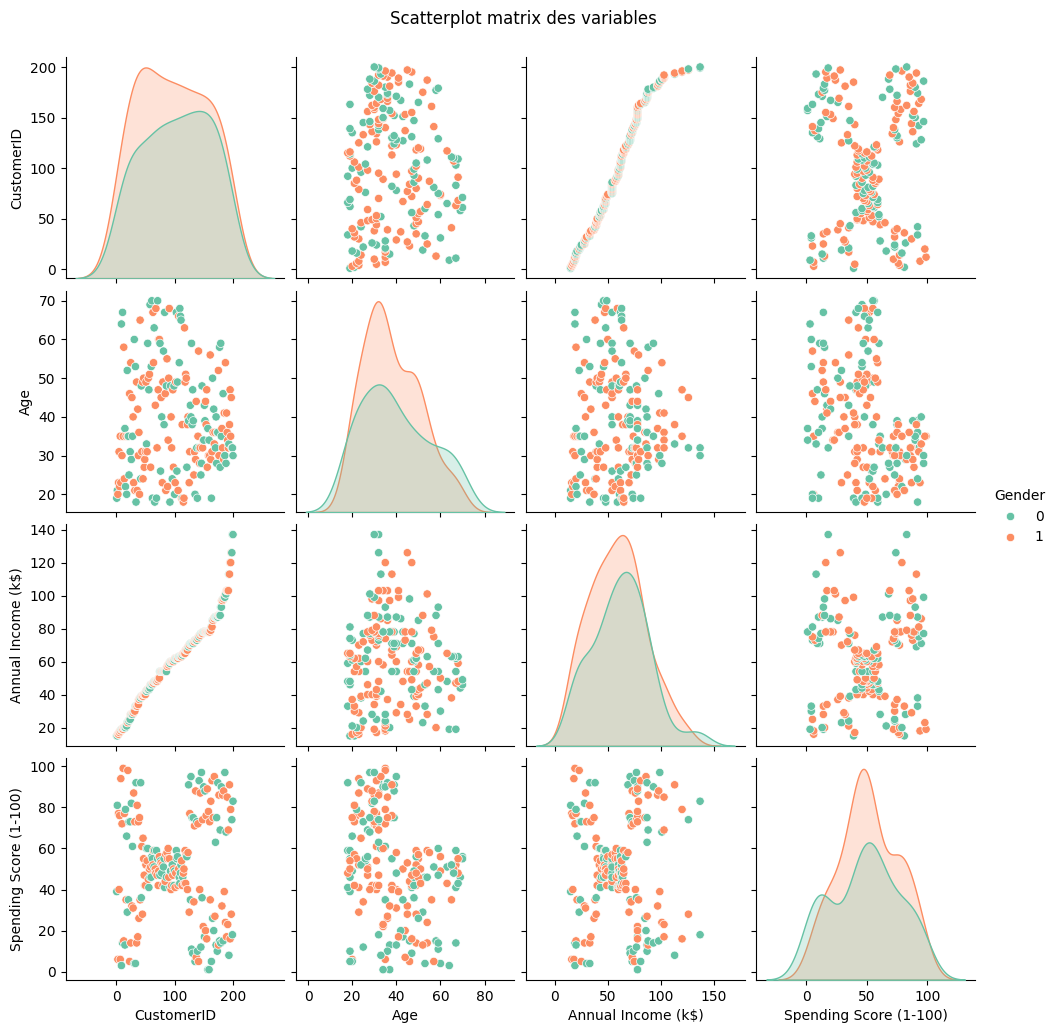

In [9]:
# 5. Scatterplot matrix (matrice de dispersion) pour explorer les relations entre variables
sns.pairplot(dataset, diag_kind='kde', hue='Gender', palette='Set2')
plt.suptitle("Scatterplot matrix des variables", y=1.03)
plt.show()

# 4. Feature engineering / sélection: 

In [10]:
# Étape de sélection de variables (Feature Selection)
## Retirer les colonnes inutiles ou sans valeur pour l’analyse
data_clean = dataset.drop(columns=['CustomerID'])
data_clean.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


In [11]:
# Création de nouvelles variables (Feature Engineering)
## Création d'une nouvelle colonne : classe d'âge
## Groupe 1 : 19 à 24 ans
## Groupe 2 : 25 à 39 ans
## Groupe 3 : 40 ans et plus

def categoriser_age(age):
    if age < 25:
        return 1
    elif age < 40:
        return 2
    else:
        return 3

data_clean['Age_Class'] = dataset['Age'].apply(categoriser_age)
data_clean.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_Class
0,0,19,15,39,1
1,0,21,15,81,1
2,1,20,16,6,1
3,1,23,16,77,1
4,1,31,17,40,2


# 5. Reduction de Dimension:


In [12]:
# Réduction de dimension avec PCA (2 composantes principales)
## On va réduire les variables explicatives à 2 dimensions pour visualisation

# Séparation des variables explicatives et de la cible
## Variables utilisées : Gender, Age, Annual Income (k$)
## Variable à prédire (exclue) : Spending Score
features = data_clean.drop(columns=["Spending Score (1-100)"])
target = data_clean["Spending Score (1-100)"]

# Initialisation et application de la PCA
pca_model = PCA(n_components=2)
pca_result = pca_model.fit_transform(features)

# Conversion du résultat PCA en DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])

# Aperçu du résultat
pca_df.head()

,PCA1,PCA2
0,-45.379430,-20.294097
1,-45.397711,-18.296332
2,-44.389681,-19.288419
3,-44.417101,-16.291770
4,-43.487397,-8.245372


# 6. Clustering

In [13]:
# Appliquer K-Means pour différents nombres de clusters (de 2 à 6)
## On stocke les métriques pour analyser les résultats
elbow_values = []
silhouette_scores = []
cluster_range = range(2, 7)

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=0)
    cluster_labels = model.fit_predict(features)

    # Sauvegarde de l'inertie pour l'Elbow Method
    elbow_values.append(model.inertia_)

    # Calcul du score de silhouette pour évaluer la qualité du regroupement
    silhouette_scores.append(silhouette_score(features, cluster_labels))

# Affichage des résultats
print("Valeurs d'inertie (Elbow) :", elbow_values)
print("Scores de silhouette :", silhouette_scores)

Valeurs d'inertie (Elbow) : [87276.01904761905, 59633.63830253587, 39639.570024280634, 33401.00222400321, 29726.07951359213]
Scores de silhouette : [0.4256972811720896, 0.4226162303283477, 0.4322287189643786, 0.3912538929622976, 0.3364578581422412]


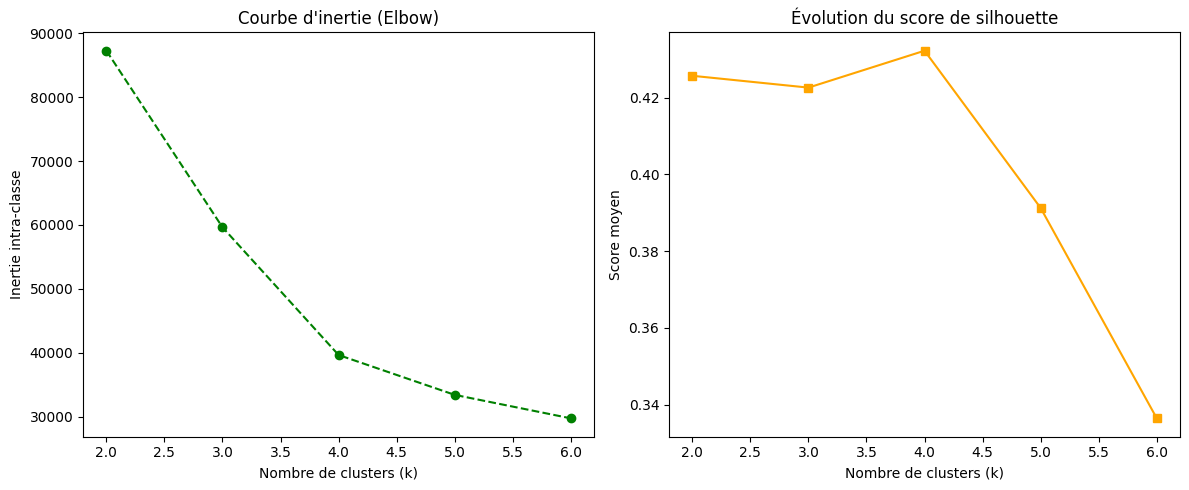

In [14]:
# Visualisation des résultats : inertie et silhouette selon le nombre de clusters
plt.figure(figsize=(12, 5))

# Graphe de l'inertie (Elbow method)
plt.subplot(1, 2, 1)
plt.plot(cluster_range, elbow_values, marker='o', linestyle='--', color='green')
plt.title("Courbe d'inertie (Elbow)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-classe")

# Graphe du score de silhouette
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', color='orange')
plt.title("Évolution du score de silhouette")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score moyen")

plt.tight_layout()
plt.show()

# 7. Interpretation des Clusters

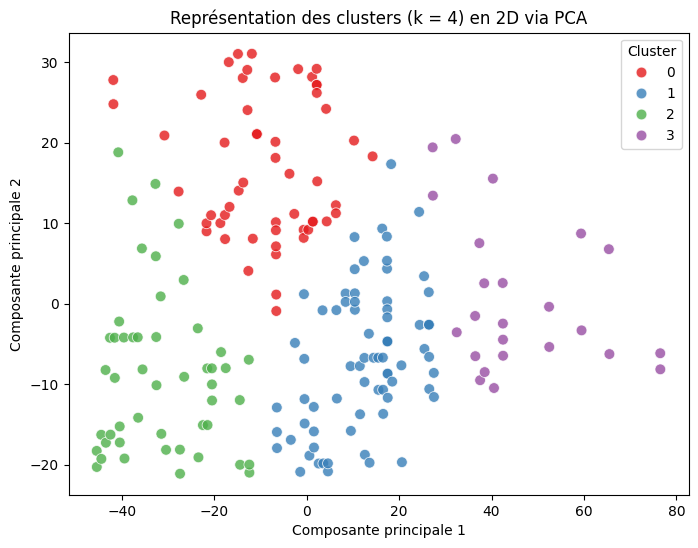

In [15]:
# Exemple de clustering avec k = 4 (choisi selon Elbow ou Silhouette)
k_optimal = 4
kmeans_model = KMeans(n_clusters=k_optimal, random_state=0)
cluster_labels = kmeans_model.fit_predict(features)

# Ajout des labels de cluster au DataFrame PCA
pca_df['Cluster'] = cluster_labels

# Visualisation en 2D (PCA) avec les clusters en couleur
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='Set1',
    s=60,
    alpha=0.8
)
plt.title(f"Représentation des clusters (k = {k_optimal}) en 2D via PCA")
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Cluster')
plt.show()


In [16]:
# Affichage des centroïdes dans l’espace original
centroides = pd.DataFrame(kmeans_model.cluster_centers_, columns=features.columns)
print("Profil moyen de chaque cluster :")
print(centroides)


Profil moyen de chaque cluster :
     Gender        Age  Annual Income (k$)  Age_Class
0  0.500000  55.814815           51.777778   2.981481
1  0.534247  31.958904           72.958904   1.972603
2  0.653061  30.346939           29.265306   1.775510
3  0.583333  39.000000          106.500000   2.375000


# 7. Conclusion

L’analyse K-Means a révélé 4 segments distincts de clients, bien séparés visuellement via la PCA.
Les scores d’inertie et de silhouette confirment que cette segmentation est pertinente.

Les groupes présentent des profils clients différents, utiles pour adapter les stratégies marketing.

Améliorations possibles :
– Tester d’autres algorithmes de clustering
– Ajouter des données comportementales ou temporelles
– Affiner l’analyse avec l’avis d’experts métier